In [86]:
import ipywidgets as widgets
from matplotlib import pyplot as plt
from ipywidgets import Image
from PIL import Image as PIL_Image

import bisect

from ipycanvas import Canvas

import numpy as np
import pandas as pd
import torch

In [87]:
import sys
sys.version

'3.12.2 (v3.12.2:6abddd9f6a, Feb  6 2024, 17:02:06) [Clang 13.0.0 (clang-1300.0.29.30)]'

In [135]:
a = 7.98
b = 1.48
c = a-b
b/c

0.2276923076923077

In [88]:
img_h = 100
img_w = 100

In [89]:
mask_fp = "../src/masks/mask_h=100_w=100_numnails=200_maxdist=0.01.npy"
with open(mask_fp, "rb") as f:
        mask = np.load(f)

array([[<Axes: title={'center': '0'}>]], dtype=object)

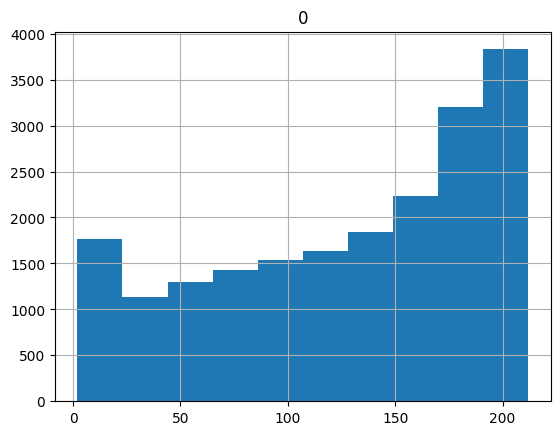

In [90]:
mask.shape
non_zero = np.count_nonzero(mask, axis=0)
pd.DataFrame(non_zero).hist()

In [91]:
non_zero

array([10, 10, 10, ...,  7,  8,  8])

In [92]:
with open("../src/output.dat", "rb") as f:
    weights = np.load(f)
# weights = torch.nn.functional.softplus(torch.from_numpy(weights), beta=20).numpy()
# weights = non_zero.max() - non_zero

array([[<Axes: title={'center': '0'}>]], dtype=object)

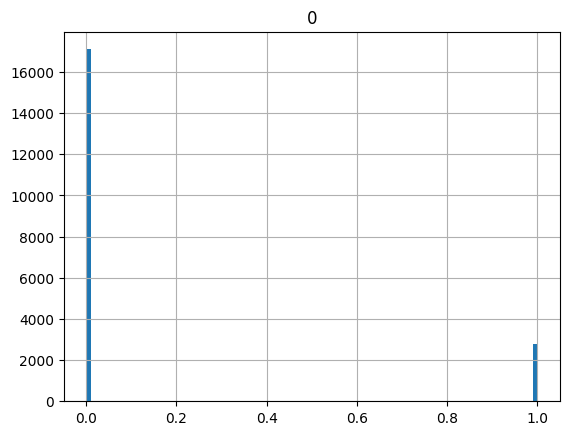

In [93]:
norm_weights = weights / weights.max()
pd.DataFrame(norm_weights).hist(bins=100)

In [94]:
(weights > 5).sum()

0

In [95]:
def parse_sequence_file(filename):
    seq = []
    with open(filename) as f:
        for line in f:
            if line.strip().startswith("----"):
                continue
            seq.extend([int(t) for t in line.split() if t.isdigit()])
    return seq

In [96]:
np.max(weights)

1.0

In [97]:
import math

In [98]:
def connection_idx(m, n):
        # (t-1) + (t-2) + ... + (t-m) + n
        # t * m - m * (m-1) / 2
        # print(f"connection_idx({m}, {n})")
        return num_nails * m - (m + 1) * m // 2 + n - m - 1

def connection_coords(idx):
    if not hasattr(connection_coords, 'coords'):
        connection_coords.coords = [(m, n) for m in range(num_nails) for n in range(m+1, num_nails)]
    return connection_coords.coords[idx]
    

In [99]:
musk_seq = parse_sequence_file("musk.txt")
np.max(musk_seq)

199

In [132]:
do_musk=False
musk_seq = parse_sequence_file("musk.txt")

with open("../src/weights_22.dat", "rb") as f:
    weights = np.load(f)
# weights = torch.nn.functional.softplus(torch.from_numpy(weights), beta=20).numpy()

print(weights.max())
print(weights.min())
print(weights.shape)

num_connections = weights.shape[0]
print(num_connections)
# quadratic formula, bitches!
num_nails = int(1/2 + np.sqrt(1/4 + 2 * num_connections))
if do_musk:
    num_nails = 200
print(num_nails)

# with open("../src/masks/mask_h=100_w=100_numnails=100_maxdist=0.1.npy", "rb") as f:
#     mask = np.load(f)

PIXELS=400

def pixel(x):
    return x * PIXELS

canvas = Canvas(width=PIXELS, height=PIXELS)

image = Image.from_file("../src/grayscale.png")
print('here')


# canvas.fill_circle(200, 200, 20)
    

canvas.stroke_style = "blue"
canvas.line_width = 0.5

string_alpha = 0.2
max_strings = 10
thresholds = [1 - (1 - string_alpha) ** i for i in range(1, max_strings)]
print(thresholds)

min = np.min(weights)
max = np.max(weights)

def draw_strings(thresh):

    # weights = np.array([mask[y_range.value *100 + x_range.value]])

    idxs = []

    points = []
    alphas = []

    if do_musk:

        for i in range(len(musk_seq) - 1):
            m = (- musk_seq[i]) % 200
            n = (- musk_seq[i+1]) % 200
            mx = (np.cos(m / num_nails * 2 * math.pi) + 1) / 2
            my = (np.sin(m / num_nails * 2 * math.pi) + 1) / 2
            nx = (np.cos(n / num_nails * 2 * math.pi) + 1) / 2
            ny = (np.sin(n / num_nails * 2 * math.pi) + 1) / 2
            points.append([[pixel(mx), PIXELS-pixel(my)], [pixel(nx), PIXELS-pixel(ny)]])
            alphas.append(0.1)

        print(len(points))
        canvas.stroke_styled_line_segments(
            np.array(points, dtype=int),
            np.array([[0, 0, 1]], dtype=int),
            np.array(alphas),
        )
    
    else:
        
    
        for m in range(num_nails):
            for n in range(m+1, num_nails):
                conn_idx = connection_idx(m, n)
                # norm_weight = weights[0][conn_idx]
                norm_weight = (weights[conn_idx] - min)/(max-min)
                # norm_weight = weights[conn_idx]/max
                # idx = bisect.bisect_right(thresholds, norm_weight)
                # idxs.append(idx)
                # continue
                # if idx > 0:
                if norm_weight > thresh:
                    # alpha = thresholds[idx-1]
                    # alpha = norm_weight
                    mx = (np.cos(m / num_nails * 2 * math.pi) + 1) / 2
                    my = (np.sin(m / num_nails * 2 * math.pi) + 1) / 2
                    nx = (np.cos(n / num_nails * 2 * math.pi) + 1) / 2
                    ny = (np.sin(n / num_nails * 2 * math.pi) + 1) / 2
                    points.append([[pixel(mx), PIXELS-pixel(my)], [pixel(nx), PIXELS-pixel(ny)]])
                    alphas.append(0.1)

    print(len(points))
    canvas.stroke_styled_line_segments(
        np.array(points, dtype=int),
        np.array([[0, 0, 1]], dtype=int),
        np.array(alphas),
    )
    
    display(canvas)

float_range = widgets.FloatSlider(value=0.99, min=0, max=1, step=0.01, continuous_update=True)
image_toggle = widgets.ToggleButtons(
    options=['Strings', 'Strings & Image', 'Image'],
    disabled=False,
    button_style='', # 'success', 'info', 'warning', 'danger' or ''
)
# x_range = widgets.IntSlider(value=50, min=0, max=100, step=1, continuous_update=False)
# y_range = widgets.IntSlider(value=50, min=0, max=100, step=1, continuous_update=False)

def draw_canvas():
    
    canvas.clear()
    canvas.stroke_circle(pixel(0.5), pixel(0.5), PIXELS/2)
    if 'Image' in image_toggle.value:
        canvas.draw_image(image, 0, 0, PIXELS, PIXELS)
    if 'Strings' in image_toggle.value:
        draw_strings(float_range.value)
        

display(image_toggle, float_range)
print('here here')
draw_canvas()

def on_float_value_change(change):
    draw_canvas()

def on_toggle_value_change(change):
    draw_canvas()
    

float_range.observe(on_float_value_change, names='value')
image_toggle.observe(on_toggle_value_change, names='value')
# x_range.observe(on_toggle_value_change, names='value')
# y_range.observe(on_toggle_value_change, names='value')

1.0
0.0
(19900,)
19900
200
here
[0.19999999999999996, 0.3599999999999999, 0.4879999999999999, 0.5903999999999999, 0.6723199999999999, 0.7378559999999998, 0.7902847999999999, 0.8322278399999999, 0.8657822719999999]


ToggleButtons(options=('Strings', 'Strings & Image', 'Image'), value='Strings')

FloatSlider(value=0.99, max=1.0, step=0.01)

here here
2800


Canvas(height=400, width=400)

In [49]:
edges = [(musk_seq[i], musk_seq[i+1]) for i in range(len(musk_seq)-1)]
from collections import Counter
Counter(edges).most_common(10)

[((0, 69), 1),
 ((69, 199), 1),
 ((199, 67), 1),
 ((67, 197), 1),
 ((197, 66), 1),
 ((66, 0), 1),
 ((0, 68), 1),
 ((68, 198), 1),
 ((198, 65), 1),
 ((65, 196), 1)]

In [210]:
import sys
from os.path import abspath
sys.path.append(abspath("../src/"))
from stringart.utils import nail_point

m_slider = widgets.IntSlider(value=num_nails/2, min=0, max=num_nails-2, step=1, description="m", continuous_update=True)
n_slider = widgets.IntSlider(value=3*num_nails/4, min=1, max=num_nails-1, step=1, description="n", continuous_update=True)
x_slider = widgets.FloatSlider(value=0.5, min=0, max=1.0, step=0.01, description="x", continuous_update=True)
y_slider = widgets.FloatSlider(value=0.5, min=0, max=1.0, step=0.01, description="y", continuous_update=True)


canvas = Canvas(width=PIXELS, height=PIXELS)
canvas.stroke_style = "red"

def draw():
    canvas.clear()

    m = m_slider.value
    n = n_slider.value
    x = x_slider.value
    y = y_slider.value
    conn_idx = connection_idx(m, n)
    arr = np.array(mask[:,conn_idx])
    arr.resize(img_h, img_w)
    
    arr = ((1 - arr/(arr.max()+1e-9)) * 250).astype('uint8')

    pimg = PIL_Image.fromarray(arr, mode="L")
    with open("timg.png", "wb") as f:
        pimg.save(f)

    img = Image.from_file("timg.png")
    canvas.draw_image(img, 0, 0, PIXELS, PIXELS)

    canvas.stroke_circle(pixel(0.5), pixel(0.5), PIXELS/2)   
    
    mx = (np.cos(m / num_nails * 2 * math.pi) + 1) / 2
    my = (np.sin(m / num_nails * 2 * math.pi) + 1) / 2
    nx = (np.cos(n / num_nails * 2 * math.pi) + 1) / 2
    ny = (np.sin(n / num_nails * 2 * math.pi) + 1) / 2
    canvas.stroke_line_segments(
        np.array([[[pixel(mx), PIXELS-pixel(my)], [pixel(nx), PIXELS-pixel(ny)]]], dtype=int),
    )
    canvas.fill_circle(pixel(x), PIXELS - pixel(y), 4)
    

    ### copied from utils
    ax, ay = nail_point(m, num_nails)
    bx, by = nail_point(n, num_nails)
    cx, cy = x, y

    if ay == by:
        dist = abs(cy - ay)
    elif ax == bx:
        dist = abs(cx - ax)
    else:

        ab_slope = (by - ay) / (bx - ax)
        ab_intercept = ay - ab_slope * ax
    
        orth_ab_slope = -1.0 / ab_slope
        orth_ab_intercept = cy - orth_ab_slope * cx
    
        cross_x = (orth_ab_intercept - ab_intercept) / (ab_slope - orth_ab_slope)
        cross_y = ab_slope * cross_x + ab_intercept
        ###
    
        ### Orthogonal line
        ox1 = 0
        oy1 = orth_ab_intercept
        ox2 = 1
        oy2 = orth_ab_slope + orth_ab_intercept
    
        canvas.fill_text(f"{orth_ab_slope:.2f}, {orth_ab_intercept:.2f}", pixel(0.2), PIXELS-pixel(0.8))
        canvas.fill_text(f"({ox1:.2f}, {oy1:.2f}), ({ox2:.2f}, {oy2:.2f})", pixel(0.2), PIXELS-pixel(0.7))
        canvas.fill_text(f"x close: {np.isclose(ax, bx)}", pixel(0.2), PIXELS-pixel(0.6))
    
        canvas.stroke_line_segments(
            np.array([[[pixel(ox1), PIXELS-pixel(oy1)], [pixel(ox2), PIXELS-pixel(oy2)]]], dtype=int),
        )
        canvas.fill_circle(pixel(cross_x), PIXELS - pixel(cross_y), 4)
    ###

def on_change(change):
    draw()

def m_slider_change(change):
    if m_slider.value >= n_slider.value:
        n_slider.value = m_slider.value+1
    on_change(change)

def n_slider_change(change):
    if m_slider.value >= n_slider.value:
        m_slider.value = n_slider.value-1
    on_change(change)
    
m_slider.observe(m_slider_change, names='value')
n_slider.observe(n_slider_change, names='value')
x_slider.observe(on_change, names='value')
y_slider.observe(on_change, names='value')

display(m_slider, n_slider, x_slider, y_slider, canvas)
draw()

IntSlider(value=100, description='m', max=198)

IntSlider(value=150, description='n', max=199, min=1)

FloatSlider(value=0.5, description='x', max=1.0, step=0.01)

FloatSlider(value=0.5, description='y', max=1.0, step=0.01)

Canvas(height=400, width=400)

In [168]:
connection_idx(73, 128)

11953

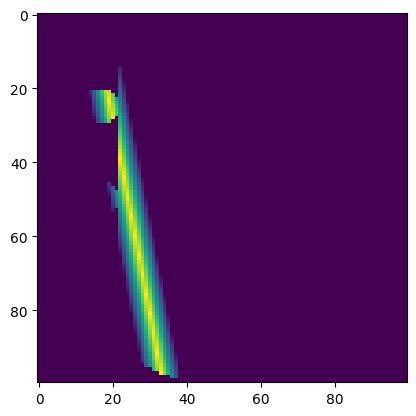

In [177]:
i = connection_idx(m_slider.value, n_slider.value)
A = np.array(mask[:,i])
A.resize(100, 100)
plt.imshow(A)

In [102]:
mask.shape

(10000, 19900)

In [122]:
pix_inf = mask.sum(axis=1)

In [123]:
pix_inf.shape

(10000,)

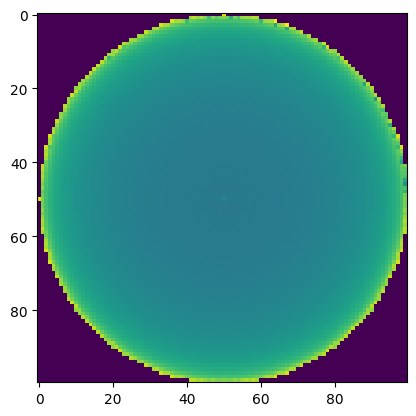

In [124]:
pix_inf.resize(100, 100)
plt.imshow(pix_inf)

In [111]:
pix_inf[50,50]

142.9268268817919

In [112]:
pix_inf[50, 2]

219.301940758221

In [114]:
nz = (mask > 0).astype(int)
max_dist=0.05
MASK = np.maximum(0, 1 - mask / max_dist) * nz

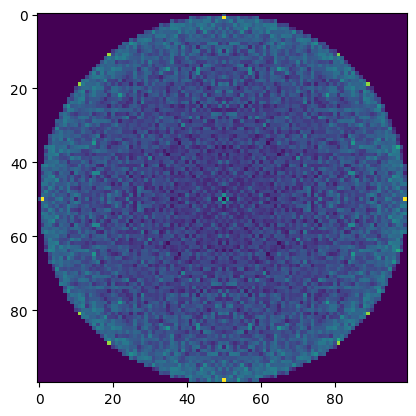

In [115]:
pix_inf = MASK.sum(axis=1)
pix_inf.resize(100, 100)
plt.imshow(pix_inf)

In [43]:
with open("../src/weights_2.dat", "rb") as f:
    weights = np.load(f)

In [44]:
weights.sum()

4690.0

In [45]:
simg = np.matmul(mask, weights)

In [42]:
simg = np.load("../src/simg.dat")

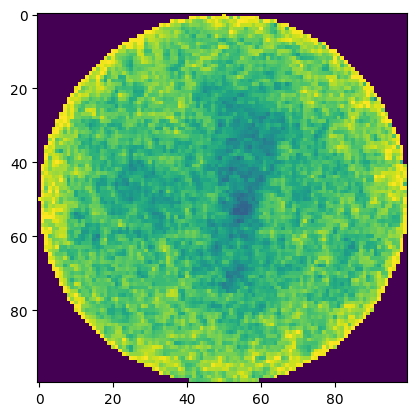

In [46]:
simg = simg.reshape(100, 100)
plt.imshow(simg)

In [115]:
img = plt.imread("../src/grayscale.png")

In [116]:
a = np.zeros((100, 100))
a[img.nonzero()] = 1

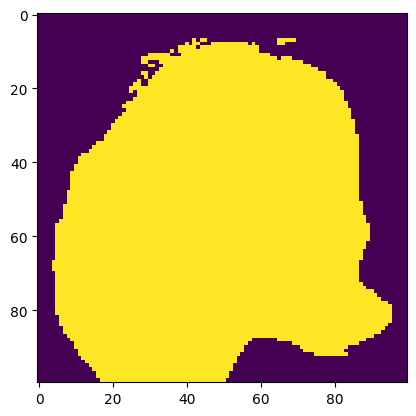

In [117]:
plt.imshow(a)